# Изучение технологии TabPFN
**TabPFN** - это модель машинного обучения для работы с табличными данными с применением предобученных трансформеров

## Импорт библиотек

In [33]:
import torch
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
from tabpfn import TabPFNClassifier
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"

df = pd.read_csv("../data/processed/train_dataset.csv", index_col=0)
df.head()

,age,education,income,has_car,car_is_foreign,has_work,has_passport,bki_score,requests_count,rejected_applications_count,region_rating,home_address_category,work_address_category,social_network_analysis_score,first_record_age,default
id,,,,,,,,,,,,,,,,
1,27,1,32000,1,1,0,0,-1.917831,0,0,40,2,3,1,4,0
2,26,2,50000,0,0,0,0,-1.153144,2,0,60,2,3,2,1,0
3,35,1,20000,0,0,1,0,-1.732810,0,0,40,1,2,4,3,0
4,35,2,80000,0,0,1,0,-2.552133,2,0,20,2,3,1,3,0
5,24,3,27000,0,0,0,0,-1.914581,1,0,50,2,3,1,2,0


In [34]:
features = df.drop(columns=["default"], axis=1)
targets = df["default"]

X_train, X_test, y_train, y_test = train_test_split(
    features, 
    targets, 
    test_size=.3,
    stratify=targets
)

In [ ]:
# Load environment
env_path = Path(".env")
load_dotenv(env_path)

!hf auth login

# Base classifier
model = TabPFNClassifier(
    balance_probabilities=True,
    device=device,
    ignore_pretraining_limits=True,
    inference_config={
        "SUBSAMPLE_SAMPLES": 10000,  
    },
    eval_metric="f1"
)

model.fit(X_train, y_train)

User is already logged in.
d:\Programming\Projects\CreditScoring\venv\Lib\site-packages\tabpfn\classifier.py:774: UserWarning: You specified 'ClassifierEvalMetrics.BALANCED_ACCURACY' as the eval metric but haven't specified any tuning configuration. For metric 'ClassifierEvalMetrics.BALANCED_ACCURACY' we recommend balancing the probabilities by class counts which can be achieved by setting `balance_probabilities` to True.
  self._maybe_calibrate_temperature_and_tune_decision_thresholds(


TabPFNClassifier(balance_probabilities=True, device='cuda',
                 eval_metric='balanced_accuracy',
                 ignore_pretraining_limits=True,
                 inference_config={'SUBSAMPLE_SAMPLES': 10000})

In [36]:
from sklearn.metrics import accuracy_score, log_loss

START = 0
END = X_test.shape[0]

# Predict class labels
preds = model.predict(X_test.iloc[START:END])
print("Accuracy:", accuracy_score(y_test.iloc[START:END], preds))

# Predict class probabilities
probs = model.predict_proba(X_test.iloc[START:END])
print("Log-Loss:", log_loss(y_test.iloc[START:END], probs))

Accuracy: 0.709355700986266
Log-Loss: 0.5471991570485124


In [37]:
import numpy as np
from typing import List
from sklearn.metrics import precision_recall_curve

def expected_cost(
    y_true: pd.Series | List | pd.DataFrame, 
    y_proba: pd.Series | List | pd.DataFrame, 
    threshold: float,
    C_fp: float,
    C_fn: float,
) -> float:
    """Returns expected cost of money losts"""
    y_pred = (y_proba >= threshold).astype(int)
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    return C_fp * fp + C_fn * fn


def optimize_threshold(
    y_true: pd.Series | List | pd.DataFrame,
    y_proba: pd.Series | List | pd.DataFrame,
    C_fp: float,
    C_fn: float,
) -> float:
    """
    Finds best threshold according to input data by optimization precision-recall curve.
    """
    # Get PRC keypoints
    prec, rec, ths = precision_recall_curve(y_true, y_proba)

    # Adds 1.0 threshold
    ths = np.append(ths, 1.0)

    # Looking for best threshold
    best_threshold, best_cost = 0.5, expected_cost(y_true, y_proba, 0.5, C_fp, C_fn)
    for t in ths:
        cost = expected_cost(y_true, y_proba, t, C_fp, C_fn)
        if cost < best_cost:
            best_cost, best_threshold = cost, t
    return best_threshold

In [38]:
best_threshold = optimize_threshold(y_true=y_test, y_proba=probs[:, 1], C_fp=1.0, C_fn=10.0)
y_pred = (probs[:, 1] > best_threshold).astype(int)

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sns.set_style("darkgrid")

def draw_confusion_matrix(
    targets: pd.DataFrame | pd.Series | List[int],
    predictions: pd.DataFrame | pd.Series | List[int],
    classes: pd.Series | List
) -> None:
    cm = confusion_matrix(targets, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.grid(False)
    plt.show()

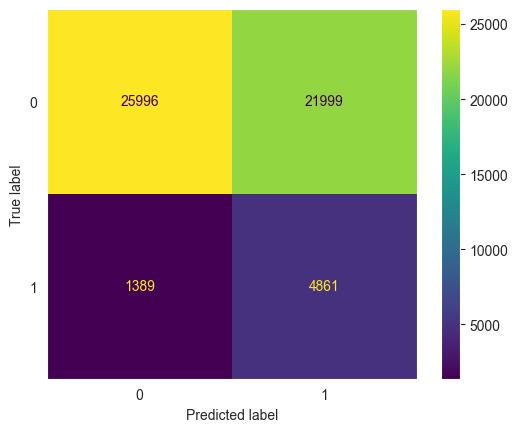

In [40]:
draw_confusion_matrix(y_test, y_pred, classes=[0, 1])

In [41]:
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score

def plot_roc( 
    targets: pd.DataFrame | pd.Series | List[int],
    predictions: pd.DataFrame | pd.Series | List[int]
):
    roc_auc = roc_auc_score(targets, predictions)

    # Для построения кривой ROC
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

def plot_pr( 
    targets: pd.DataFrame | pd.Series | List[int],
    predictions: pd.DataFrame | pd.Series | List[int]
):
    pr_auc = average_precision_score(targets, predictions)

    # Для построения кривой ROC
    fpr, tpr, thresholds = precision_recall_curve(targets, predictions)
    plt.plot(fpr, tpr, label=f"PR curve (AUC = {pr_auc:.2f})")
    plt.plot([0, 1], [1, 0], linestyle="--", color="gray")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

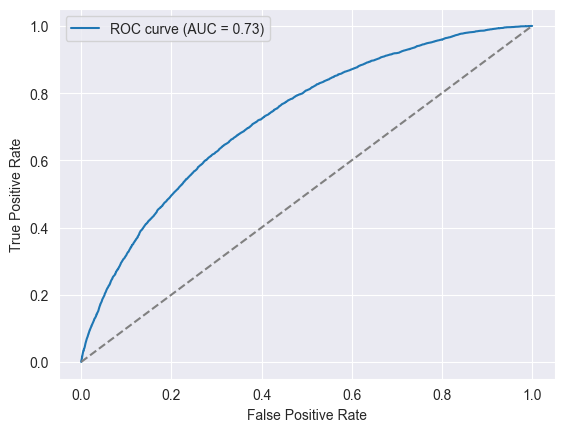

In [42]:
plot_roc(targets=y_test, predictions=probs[:, 1])